# NanoGPT

> ### Authors: Yunhao Cao, Carl (Qianxin) Gan, Kevin (Yuxi) Liu

## License Information
Copyright 2023 Yunhao Cao, Qianxin Gan, Yuxi Liu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Introduction

In this homework assignment, you are tasked with reimplementing and understanding the key aspects
of a groundbreaking paper in natural language processing. The paper demonstrates that language
models can learn various NLP tasks, such as question answering, machine translation, reading com-
prehension, and summarization, without explicit supervision when trained on a massive dataset called
WebText, which consists of millions of webpages.

The goal is to examine how language models, when conditioned on a document and a set of
questions, can generate answers that achieve competitive performance on the CoQA dataset. You will
explore the importance of the language model’s capacity in zero-shot task transfer and its impact on
performance across tasks. Your primary focus will be on the largest model, GPT-2, a 1.5B parameter
Transformer that achieves state-of-the-art results on 7 out of 8 tested language modeling datasets in
a zero-shot setting.

By re-implementing this paper and examining the model’s generated samples, you will gain a
deeper understanding of the potential for building language processing systems that learn to perform
tasks from naturally occurring demonstrations.

In this assignment, you will learn to implement a GPT model from scratch. This includes implementing the Transformer architecture (with causal input mask), the GPT model, a byte-level BPE tokenizer, the embedding layer, and the positional encoding layer.
We will also train a GPT-2 Model to generate "Shakespeare-like" text, so that you can play around on your own and see some of its potential! Here's the original paper for reference: ([Original Paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf)) 

## Initial Setup

### Mount Google Drive (skip if not using Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Clone GitHub Repository (skip if not using Colab)

In [ ]:
import os
if not os.path.exists("CS182_FP_Final"):
  !git clone https://github.com/KevinLiu819/CS182_FP_Final
%cd CS182_FP_Final

### Install Python packages (skip if already installed)

In [ ]:
%pip install einops

### Import Python packages

In [ ]:
# Imports
from grader import *
import typing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import math
import matplotlib.pyplot as plt

### Set up autograder submitter

In [ ]:
# Set up autograder submitter
submitter = AutograderSubmitter()

## Part 1: Tokenizer

To transform text into a format that can be used by a neural net, we need to first tokenize it (That is, transform the text corpus into indexes of our dictionary). The GPT-2 model uses a byte-level BPE tokenizer. 

Before we start, please first take a look at [this tutorial video by Huggingface](https://youtu.be/HEikzVL-lZU)

In the tutorial video above, you see that a BPE tokenizer starts with a base dictionary set of characters. Those "base set of characters" are usually represented by unicode characters. Unicode characters are the standard way to represent all possible human languages plus our favorite emojis 😀😙 in byte streams. There are multiple Unicode standards: UTF-8, UTF-16, UTF-32, etc. However, because unicode characters are not very memory efficient, this basically means that we need to start with a **huge** base dictionary size to begin with our tokenizer. And this is why the authors of GPT-2 chose to instead use a byte-level BPE tokenizer. That is, we split characters into futher smaller fragments (1 byte, or 8-bits) and use those as our base dictionary. This way, we can reduce the base dictionary size from 100,000+ unicode characters to just 256.

> As a side note, the UTF-8 standard is not a strict 8-bit-per-character standard and each character in a UTF-8 stream can take more than 8 bits. 

To implement a byte-level BPE tokenizer, we need to first create a base dictionary of 256 characters. This base dictionary will be constructed and passed into our `Dictionary` class via the `__init__` method. Then we need to be able to expand our vocabulary list, one at a time. We will do this by implementing both the `expand_dictionary` method and the `find_combinations_to_expand` method.

Basically, think about our current dictionary as all possible alphabets and a space. We would first tokenize our text into a list of indexes in our dictionary. Then we will enumerate through the list of indexes and find the most frequent pair of indexes that appear next to each other. We will then combine those two indexes (of the most frequent pair) into a new index and add it to our dictionary. We will repeat this process until we reach our desired vocabulary size.

There are two member attributes of the `Dictionary` class, `dictionary_array` and `combinations_to_index`. The `dictionary_array` attribute simply holds all the vocabularies and `combinations_to_index` is used later in `tokenize()`.

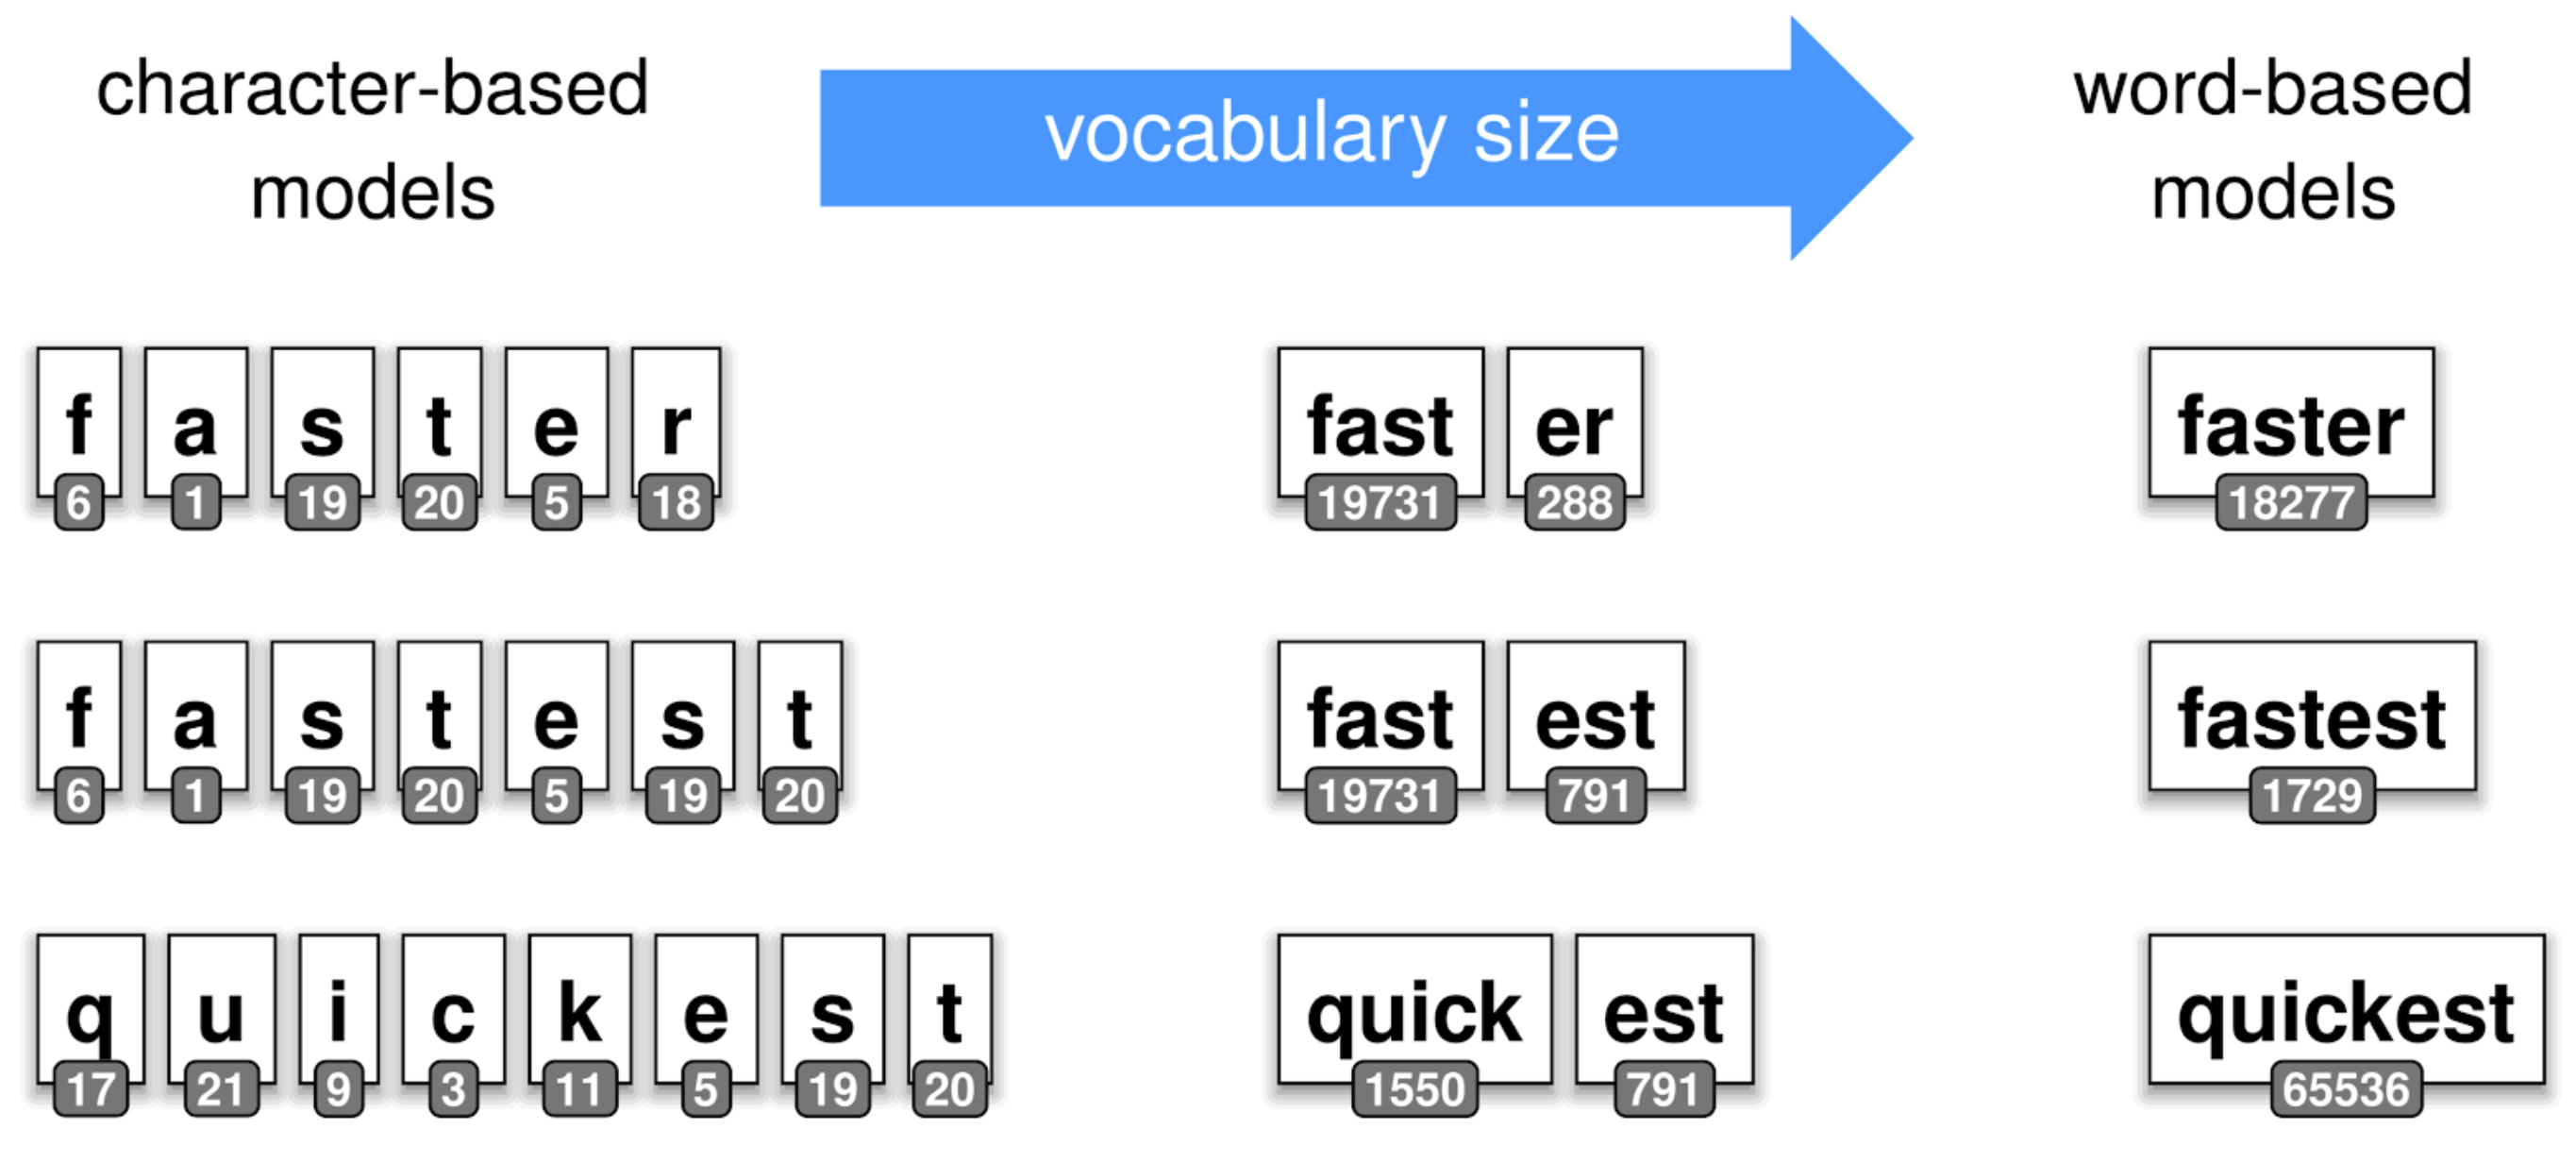

In [ ]:
class Dictionary:
    def __init__(self, base_dictionary : typing.List[bytes] = [i.to_bytes(1,'big') for i in range(256)]) -> None:
        
        # dictionary holds all volcabulary items and the index of each item in this array will be the input idx to the model
        self.dictionary_array : typing.List[bytes] = base_dictionary.copy()

        # This is a dictionary that maps a combination of two vocab items to a later vocab item
        self.combinations_to_index : typing.Dict[typing.Tuple[int, int], int] = {}
    
    def __len__(self) -> int:
        return len(self.dictionary_array)
    
    def __getitem__(self, key: int) -> str:
        return self.dictionary_array[key]
    
    def __contains__(self, key: str) -> bool:
        return key in self.dictionary_array
    
    def expand_dictionary(self, combination_vocab : typing.Tuple[int, int]) -> None:
        """
        This function should expand the dictionary with one more vocabulary item, 
        the item should be the concatenation of the two vocab items in combination_vocab
        You need to modify both the dictionary_array and combinations_to_index

        Parameters
        ----------
        combination_vocab : typing.Tuple[int, int]
            The combination of two vocab items to expand the dictionary with
        """
        # YOUR CODE HERE
        self.dictionary_array.append(self.dictionary_array[combination_vocab[0]] + self.dictionary_array[combination_vocab[1]])
        self.combinations_to_index[combination_vocab] = len(self.dictionary_array) - 1
    

    def find_combination_to_expand(self, corpus_of_text: typing.List[int]) -> typing.Tuple[int, int]:
        """
        This function should find the combination of two vocab items that occurs the most in the corpus of text and return it
        
        Parameters
        ----------
        corpus_of_text : typing.List[int]
            The corpus of text represented by a list of integers (with each integer representing a vocab in the dictionary) to expand the dictionary with
        """
        # YOUR CODE HERE
        count_dict = {}
        for i in range(len(corpus_of_text) - 1):
            if (corpus_of_text[i], corpus_of_text[i+1]) in count_dict:
                count_dict[(corpus_of_text[i], corpus_of_text[i+1])] += 1
            else:
                count_dict[(corpus_of_text[i], corpus_of_text[i+1])] = 1
        return max(count_dict, key=count_dict.get)


In [ ]:
# Check your implementation
grade_dictionary_class_expand_dictionary(Dictionary())
grade_dictionary_class_find_combination_to_expand(Dictionary())
submitter.submission_data["tokenizer_comb"] = generate_dictionary_class_find_combination_to_expand_dat(
    Dictionary()
)

Awesome! Now we're able to expand our vocabulary list. But how do we tokenize our text into a list of indexes? We will do this by implementing the `tokenize` function. 

In [ ]:
def tokenize(text : str, dictionary : Dictionary) -> typing.List[int]:
    """
    This function should tokenize the text using the dictionary and return the tokenized text as a list of integers

    Parameters
    ----------
    text : str
        The text to tokenize
    
    dictionary : Dictionary
        The dictionary to use for tokenization
    """

    text_bytestream = bytes(text, "utf-8") # convert text to bytestream
    tokenized_text : typing.List[int] = [] # initialize tokenized text
    for i in range(len(text_bytestream)):
        tokenized_text.append(
            dictionary.dictionary_array.index(text_bytestream[i:i+1])
        )
    
    num_tokenized_last_pass = len(tokenized_text)
    # We will sweep through the tokenized text and replace any combination of two vocab items with the later vocab item
    while num_tokenized_last_pass > 0:
        # YOUR CODE HERE
        num_tokenized_last_pass = 0
        new_tokenized_text = []
        for i in range(len(tokenized_text) - 1):
            if (tokenized_text[i], tokenized_text[i+1]) in dictionary.combinations_to_index:
                new_tokenized_text.append(dictionary.combinations_to_index[(tokenized_text[i], tokenized_text[i+1])])
                num_tokenized_last_pass += 1
            else:
                new_tokenized_text.append(tokenized_text[i])
                if i == len(tokenized_text) - 2:
                    new_tokenized_text.append(tokenized_text[i+1])
        
        tokenized_text = new_tokenized_text
    
    return tokenized_text


In [ ]:
grade_tokenizer(tokenize, Dictionary())
submitter.submission_data["tokenizer"] = generate_tokenizer_submission(tokenize, Dictionary())

### Follow-up Question

Once you have passed the test, think about why Byte Pair Encoding outperforms many other traditional tokenizers. Write down your answer and include it in your written response. *Hint: think about how BPE handles words that are not in the dictionary (unknown words) more effectively and how BPE is different in the process of tokenization.*

>SOLUTION

Byte Pair Encoding (BPE) is a subword tokenization algorithm that handles unknown words more effectively compared to other tokenizers. In most traditional tokenizers, if a word is not in the vocabulary, it is treated as an unknown word and assigned a special token, often <UNK>. This results in a loss of information about the unknown word, making it challenging for the model to predict or generate the correct word during the inference process.

BPE, on the other hand, alleviates this problem by breaking down words into subword units. It starts by tokenizing the text at the character level and then iteratively merges the most frequent pairs of characters or character sequences to create subwords. This process continues until a predefined vocabulary size is reached or no more merges are possible. The resulting vocabulary consists of a mix of whole words, subword units, and individual characters.

When BPE encounters an unknown word, it can break it down into its subword units, which are likely present in the vocabulary. This allows the model to better understand and represent the unknown word, even if it has not seen the exact word during training. By preserving information about the unknown word's structure, BPE enables more accurate predictions and text generation, as the model can leverage the subword information to infer the correct word or generate similar words.

### Position Embeddings
Next we will implement the token embeddings and positional embeddings. The positional embeddings are used to encode the position of each token in the sequence. The positional embeddings are added to the token embeddings before being passed into the Transformer.

We will represent our token embeddings as a `torch.nn.Embedding` layer. The positional embeddings will be represented as fixed buffer just like in the original `Attention is all you need` paper.

Please notice that formula for position embedding is

$$
PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})
$$

$$
PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})
$$

where $pos$ is the position and $i$ is the dimension.

You just need to implement initilization of the PE matrix here.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout = 0.1, max_len: int = 1024):
        super().__init__()
        pe = self.calculate_pe(d_model, max_len)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)

    def calculate_pe(self, d_model : int, max_len : int):
        """
        Calculate positional encoding for transformer

        Parameters
        ----------
        d_model : int
            The dimension of each embedding token
        
        max_len : int
            The maximum length of the sequence

        Returns
        -------
        pe : Tensor
            The positional encoding tensor of shape ``[1, max_len, d_model]``
        """
        # YOUR CODE HERE
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)).unsqueeze(0)
        pe = torch.zeros(1, max_len, d_model)
        combined_term = position * div_term
        pe[0, :, 0::2] = torch.sin(combined_term)
        pe[0, :, 1::2] = torch.cos(combined_term)
        return pe

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:,:x.shape[1],:]
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, max_len: int = 1024, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            tokens: Tensor, shape ``[batch_size, seq_len]``
        """
        return self.pe(torch.arange(tokens.shape[1], device=tokens.device)) + self.embedding(tokens) 

In [ ]:
# Check your implementation
grade_pe(PositionalEncoding(6,0.0,128))
submitter.submission_data["PE"] = generate_pe_sub(PositionalEncoding(12,0.0,256))

## Part 2: Transformer Layer

### Multi-Head Attention

Great job on implementing Part 1! In Part 2, we will implement the transformer layer. The first step in building the transformer layer is multi-head attention. Let's understand how attention works. The motivation behind attention is that some parts of our input data are more important than others. We only want to focus on the important parts of the data. The attention mechanism achieves this by using a set of queries, keys, and values generated from the input tokens. A similarity score is produced between a query $q_i$ and a key $k_j$ and higher similiarity scores means token $i$ should attend to token $j$ more. 

GPT-2 is an auto-regressive model (i.e. it predicts future tokens given previous data). GPT-2 uses masked attention because we want to mask the information about future tokens. If we had information about future tokens, this would be considered cheating because the model would know what to output. GPT-2 uses multi-headed attention, or multiple attention heads. Using multiple heads is useful because it enables the model to attend to parts of the sequence differently. You can think of it as enabling more expressivity in communication amongst tokens.

In this section, we implement multi-headed attention head in the following steps:
1. Generate queries, keys, and values from the input tokens (computed in the previous part)
2. Use the queries, keys, and values to compute masked attention
3. Apply a linear projection and dropout to the masked attention

Here is how attention is calculated: 

$$
Attention = Softmax(Mask(\frac{QK^T}{\sqrt{d_{head}}}))V
$$
where $d_{head}$ is the embedding dimension of each head, $n_{heads}$ is the number of heads, and $d_{model} = n_{heads} * d_{head}$.

**Note:** The input `x` is of size `(batch_size, seq_len, d_model)` and the output is of size `(batch_size, tgt_len, d_model)`. However, the attention function should take in queries of size `(batch_size, n_heads, tgt_len, d_head)` and keys and values of size `(batch_size, n_heads, seq_len, d_head)`. Thus, we need to rearrange the input and attention output somehow to match the different dimensions. Also note that for self-attention, `tgt_len == seq_len` since we are passing the input `x` as the queries, keys, and values.

*Hint 1: `einops.rearrange` may be helpful here. You can reference the documentation here: https://einops.rocks/api/rearrange/. We've included the `einops` package for you already.*

*Hint 2: To apply the mask before applying softmax, we want to set the weights we want to mask out to $-inf$ so that softmax ignores those weights. We want something like $\begin{bmatrix} W_{11} & -inf & -inf & ...\\ W_{21} & W_{22} & -inf & ...\\ W_{31} & W_{32} & W_{33} & ...\\ ... & ... & ... & ... \\ \end{bmatrix}$ where $W = \frac{QK^T}{\sqrt{d_{head}}}$. `torch.tril` and `torch.Tensor.masked_fill` may be helpful here.*




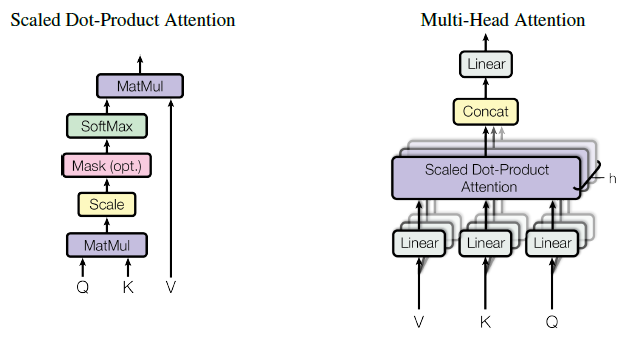

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.output_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def compute_masked_attention(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        """
        Calculate masked attention for transformer

        Parameters
        ----------
        Q: Input tensor of queries with size (batch_size, n_heads, tgt_len, d_head)
        K: Input tensor of keys with size (batch_size, n_heads, seq_len, d_head)
        V: Input tensor of values with size (batch_size, n_heads, seq_len, d_head)

        Returns
        -------
        Output attention tensor with size (batch_size, n_heads, tgt_len, d_head)
        """
        # YOUR CODE HERE
        _, _, seq_len, d_head = Q.shape
        weights = Q @ K.transpose(-2, -1) / (d_head ** 0.5)
        mask = torch.tril(torch.ones((seq_len, seq_len), device=Q.device))
        masked_weights = weights.masked_fill(mask == 0, float('-inf'))
        return nn.functional.softmax(masked_weights, -1) @ V
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for multi-headed attention

        Parameters
        ----------
        x: Input tensor of tokens with size (batch_size, seq_len, d_model)

        Returns
        -------
        Output tensor after forward pass with size (batch_size, tgt_len, d_model)
        """
        # YOUR CODE HERE
        Q = self.query_proj(x)
        K = self.key_proj(x)
        V = self.value_proj(x)
        Q = einops.rearrange(Q, 'a b (c d) -> a c b d', c=self.n_heads)
        K = einops.rearrange(K, 'a b (c d) -> a c b d', c=self.n_heads)
        V = einops.rearrange(V, 'a b (c d) -> a c b d', c=self.n_heads)
        attention = self.compute_masked_attention(Q, K, V)
        attention = einops.rearrange(attention, 'a c b d -> a b (c d)', c=self.n_heads)
        out = self.output_proj(attention)
        return self.dropout(out)

In [ ]:
# Test your implementation
grade_attention(MultiHeadAttention)
submitter.submission_data["Attention"] = generate_attention_sub(MultiHeadAttention)

### Feed-Forward Block

Awesome! Now that we have implemented multi-head attention, the next step is to implement the feed-forward block. The feed-forward block is just two linear layers with ReLU in between and dropout at the end. Based on the *Attention is all you Need (Vaswani et al.)* paper, they made the hidden layer dimension of size $4 * d_{model}$ and input and output dimensions of size $d_{model}$. 

**Note:** GPT-2 uses GeLU activation instead of ReLU activation. GeLU activation is slightly different in that it is smoother than ReLU. You can reference this paper (https://arxiv.org/pdf/1606.08415v3.pdf) to get a better understanding of GeLU, but we have provided the code to calculate GeLU for you already.


In [ ]:
def gelu(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, 4 * d_model)
        self.gelu = gelu
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for feed-forward block

        Parameters
        ----------
        x: Input tensor of tokens with size (batch_size, seq_len, d_model)

        Returns
        -------
        Output tensor after forward pass with size (batch_size, seq_len, d_model)
        """
        # YOUR CODE HERE
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [ ]:
# Test your implementation
grade_feed_forward(FeedForward)
submitter.submission_data["FeedForward"] = generate_feed_forward_sub(FeedForward)

### Transformer Layer

Great! Now we can combine everything into one transformer block. The transformer block involves multi-head attention and the feed-forward step with layer normalizations and residual connections in between. The layer norms and residual connections help prevent vanishing and exploding gradients. We don't use batch norm here because it doesn't make sense to normalize across different examples in a batch for a single feature, especially when the examples can vary in length. 

Now implement the transformer layer, which is the attention block and feed-forward block with two layer-norms and residual connection in between.

**Note:** GPT-2 is a bit different than the *Attention is all you Need (Vaswani et al.)* paper and adds a residual connection after the layer normalization. That is, we compute $residual + LayerNorm(x)$ instead of $LayerNorm(x + residual)$.

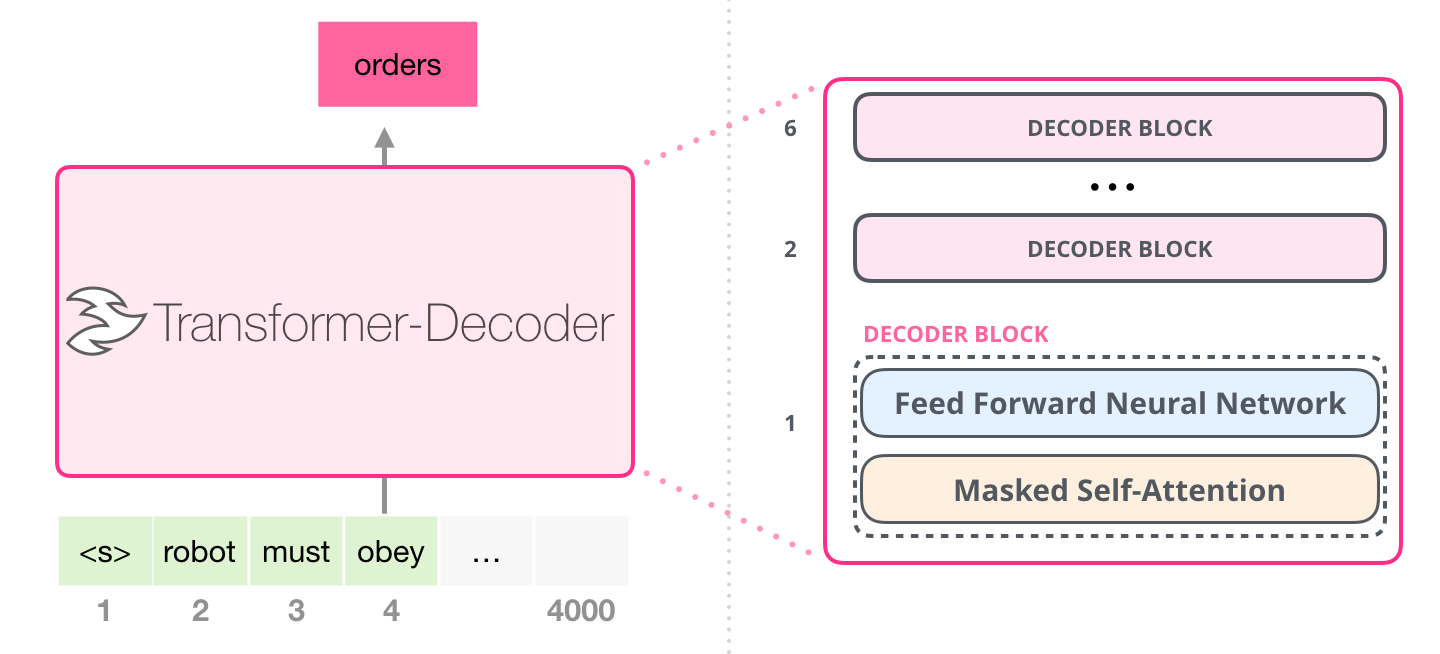

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.attention_layer = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, dropout)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for transformer layer

        Parameters
        ----------
        x: Input tensor of tokens with size (batch_size, seq_len, d_model)

        Returns
        -------
        Output tensor after forward pass with size (batch_size, seq_len, d_model)
        """
        # YOUR CODE HERE
        attention = self.attention_layer(x)
        x = x + self.norm1(attention)
        out = self.feed_forward(x)
        out = x + self.norm2(out)
        return out

In [ ]:
# Test your implementation
grade_transformer_layer(TransformerLayer)
submitter.submission_data["TransformerLayer"] = generate_transformer_layer_sub(TransformerLayer)

## Part 3: GPT-2 Model and Training


### GPT-2 Model

Awesome work! Now that we have all the essential components, we can proceed to implement the GPT model. The model follows the outlined structure here, but please feel free to tweak with the model afterwards. **Note:** We will be adding softmax later during training, so it is not needed here.

1. Token Embedding
2. Transformer Layers
3. Final Linear Layer

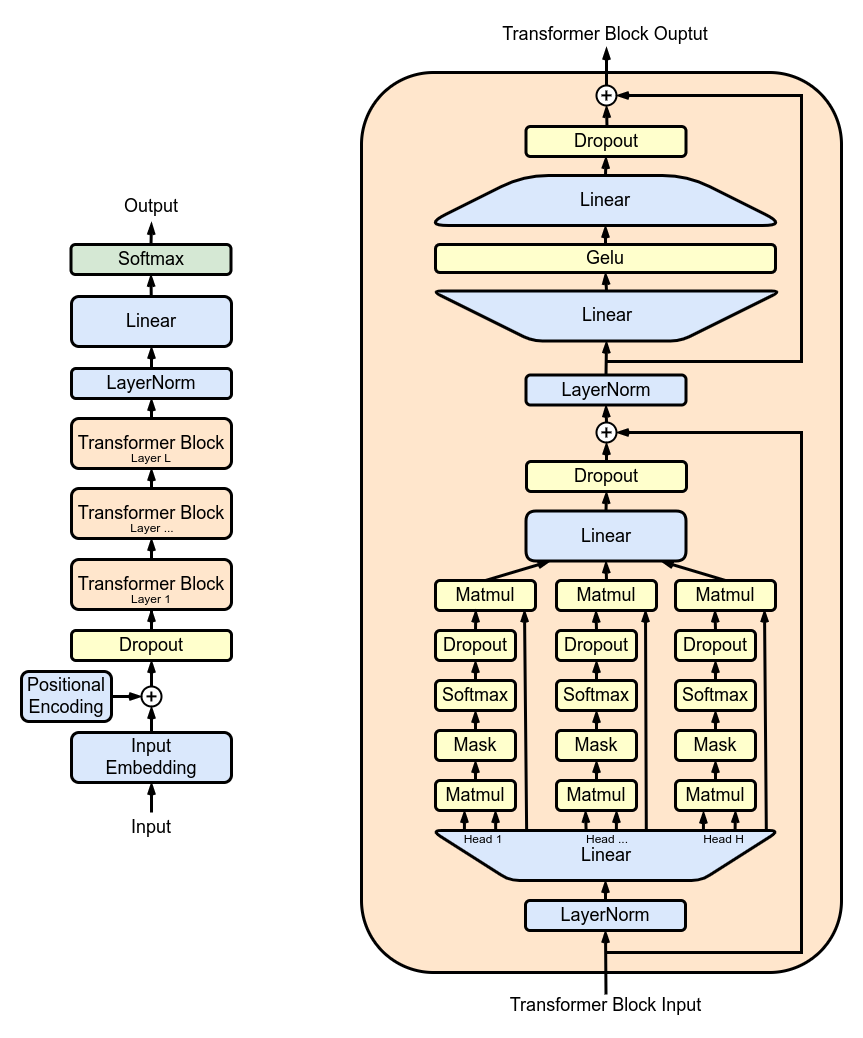

In [ ]:
class GPT2(nn.Module):
    """
    GPT-2 model implementation.

    Parameters
    ----------
    vocab_size : int
        The size of the vocabulary used in the model.
    d_model : int
        The dimension of the token embeddings and transformer layers.
    n_layers : int
        The number of transformer layers in the model.
    n_heads : int, optional, default=4
        The number of attention heads in the multi-head self-attention mechanism.
    dropout : float, optional, default=0.1
        The dropout probability for the model.

    Attributes
    ----------
    token_embedding : TokenEmbedding
        The token embedding layer.
    transformer_layers : nn.ModuleList
        The list of transformer layers.
    fc : nn.Linear
        The final linear layer that projects the output to the size of the vocabulary.
    """
    def __init__(self, vocab_size: int, d_model: int, n_layers: int, n_heads: int = 4, max_len: int = 1024, dropout: float = 0.1):
        super().__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model, max_len, dropout)
        self.transformer_layers = nn.ModuleList([TransformerLayer(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the GPT model
        
        Parameters
        ----------
        tokens: torch.Tensor
            input tensor of tokens with size (batch_size, seq_len)

        Returns
        -------
        torch.Tensor
            Output tensor after forward pass with size (batch_size, seq_len)
        """
        # YOUR CODE HERE
        x = self.token_embedding(tokens)
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.fc(x)
        return x


In [ ]:
# Test your implementation
test_gpt2_model(GPT2)

### Training

In this part, we will implement the training function for our GPT-2 model. We have provided some parts of the code for you, but you will need to implement each training and validation iteration.

*Hint 1: Make sure for each training step to run `optimizer.zero_grad()`, `optimizer.step()`, and `train_loss.backward()` to perform backprop. Validation steps do not require this since we don't perform backprop. Training and validation should be very similar.*

*Hint 2: You may find `einops.rearrange` to be helpful. It may also be helpful to look into `torch.nn.functional.cross_entropy` documentation (https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html).*


In [ ]:
def train_gpt(model, optimizer, train_dataloader, val_dataloader, epochs: int, device='cpu'):
    """
    Train the GPT-2 model.

    Parameters
    ----------
    model : GPT2
        The GPT-2 model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer used for updating the model's weights.
    criterion : torch.nn.Module
        The loss function used for training.
    dataloader : torch.utils.data.DataLoader
        The DataLoader used for iterating over the training data.
    epochs : int
        The number of epochs to train the model.
    device : torch.device
        The device on which the model will be trained (e.g., 'cpu' or 'cuda'),
        defaulted to cpu.
    """
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(epochs):
        # Training
        iters = 0
        for batch in train_dataloader:
            tokens = batch["tokens"].to(device)
            labels = batch["labels"].to(device)

            # START CODE HERE
            logits = model(tokens)
            logits = einops.rearrange(logits, 'a b c -> a c b')
            train_loss = torch.mean(F.cross_entropy(logits, labels)) 
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            # END CODE HERE

            iters += 1
            if iters == 100:
                break

        # Validation
        iters = 0
        with torch.no_grad():
            for batch in val_dataloader:
                tokens = batch["tokens"].to(device)
                labels = batch["labels"].to(device)

                # START CODE HERE
                logits = model(tokens)
                logits = einops.rearrange(logits, 'a b c -> a c b')
                val_loss = torch.mean(F.cross_entropy(logits, labels))
                # END CODE HERE
                
                iters += 1
                if iters == 100:
                    break

        # Logging
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        print(f"Epoch: {epoch + 1}/{epochs}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")
    
    return train_losses, val_losses

In [ ]:
# Test your implementation
test_train_gpt2(GPT2, train_gpt)

## Part 4: Training GPT to Generate Shakespeare

Now that we have implemented the entire GPT-2 model and training, we are ready to see its applications! In this part, we will be training our GPT-2 model from scratch to generate "Shakespeare-like" text. We will be feeding in a text file of Shakespeare's works. To look into the contents of the text file you can open `data/tiny_shakespeare.txt`. Your task in this part will be to finetune the model hyper-parameters to produce somewhat comprehensible "Shakespeare-like" text. 

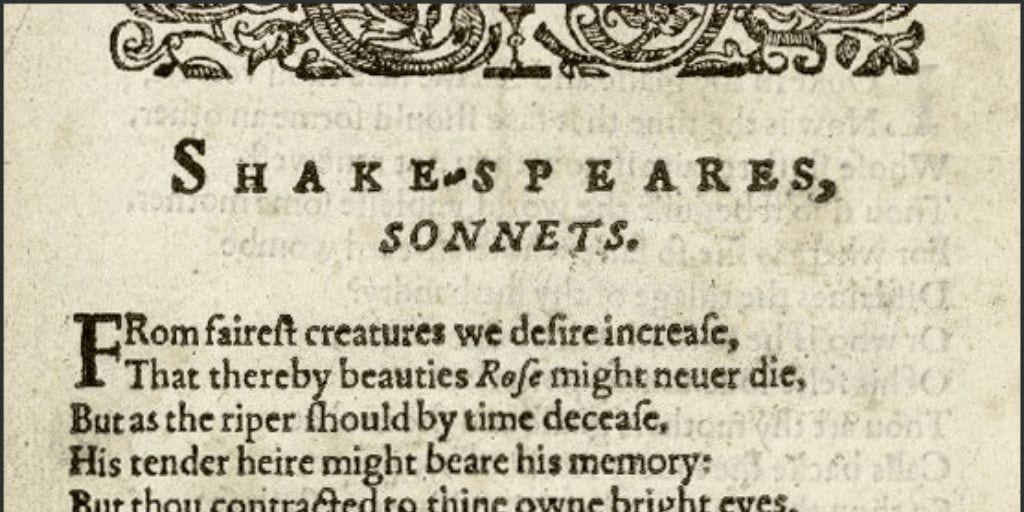

### Load the data and helper functions

In [ ]:
# Load the data
with open("data/tiny_shakespeare.txt", "r") as f:
    data = f.read()
n = len(data)
vocab = sorted(list(set(data)))
vocab_size = len(vocab) # 65
dictionary = { ch: i for i, ch in enumerate(vocab) }
tokenize_shakespeare = lambda s: [dictionary[c] for c in s]
split_train_val = 0.9 # 90% training data, remaining 10% validation data
train_data = torch.tensor(tokenize_shakespeare(data[:int(split_train_val * n)]), dtype=torch.long)
val_data = torch.tensor(tokenize_shakespeare(data[int(split_train_val * n):]), dtype=torch.long)

# Data loader class
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, batch_size, block_size, use_train = True):
        self.batch_size = batch_size
        self.block_size = block_size
        self.use_train = use_train

    def __len__(self):
        if self.use_train:
            return len(train_data) - self.block_size
        else:
            return len(val_data) - self.block_size
    
    def __getitem__(self, idx):
        dataset = train_data if self.use_train else val_data
        x = dataset[idx:idx + self.block_size]
        y = dataset[idx + 1:idx + 1 + self.block_size]
        return {"tokens": x, "labels": y}

# Generate function
def generate(model, num_tokens, block_size, device):
    tokens = torch.zeros((1, 1), dtype=torch.long, device=device)
    with torch.no_grad():
        for _ in range(num_tokens):
            logits = model(tokens[:, -block_size:])
            logits = logits[:, -1, :]
            probs = nn.functional.softmax(logits, dim=-1)
            token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat((tokens, token), dim=-1)
    tokens = torch.squeeze(tokens)

    text = ""
    for token in tokens:
        text += vocab[token]
    return text

### Set hyper-parameters for training

In this part, you can modify the parameters for finetuning and see how the model performs. We recommend scaling up some of the parameters but not by too much, otherwise the model may take too long to train. For this part, make sure you are also running on GPU, otherwise training will be very slow. 

Note that we do not use accuracy as a metric here because it would be quite low due to the large number of different possible tokens that can be outputted by the model. We measure by average cross-entropy loss because the loss compares the expected output with the softmax of the logits instead, which is smoother.

You will be graded based on the final validation loss. You should achieve a final validation loss ≤ 2 in order to receive full credit. A final validation loss of ≥ 3 will be consider no credit, and any loss between 2 and 3 will be scaled linearly. 

$$Score = max(0, min(1, 3 - FinalValLoss))$$

For reference, our solution is able to achieve about 1.7 validation loss in about 5 minutes with 10 epochs.

In [ ]:
# MODIFY CODE HERE
batch_size = 64
d_model = 384
n_layers = 6 
n_heads = 6
dropout = 0.2 
block_size = 100 
epochs = 10
weight_decay = 1e-3
learning_rate = 3e-4

### Initialize, train, and test model

In [ ]:
# Initialize model
model = GPT2(vocab_size, d_model, n_layers, n_heads, block_size, dropout)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_dataset = ShakespeareDataset(batch_size, block_size, True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ShakespeareDataset(batch_size, block_size, False)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Train and test model
train_losses, val_losses = train_gpt(model, optimizer, train_dataloader, val_dataloader, epochs, device)
final_loss = val_losses[-1]

# Save for autograder
submitter.submission_data["Shakespeare"] = final_loss

### Visualize Training and Validation Losses

In [ ]:
# Training Loss Graph
plt.plot(np.arange(1, epochs + 1), train_losses)
plt.title("Training Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

# Validation Loss Graph
plt.plot(np.arange(1, epochs + 1), train_losses)
plt.title("Validation Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

### Generate some outputs

Here is the fun part! You can see what your model generates after training. Feel free to change the number of tokens and run the code cell multiple times to see the different outputs that can be produced.

In [ ]:
num_tokens = 500 # FEEL FREE TO MODIFY THIS VALUE
print(generate(model, num_tokens, block_size, device))

### Follow-up Questions

1. Please upload the 500-token text that your GPT model generates.
2. Comment on what you observe about the resulting text (~100 words).

## Analytical Questions

Congratulations on successfully implementing your own GPT-2 model! It is now a good time to take a step back and think about GPT-2 as a whole. Answer the following questions in your written submission:
1. How does the model size (number of parameters) affect the quality of generated text and the ability to learn different tasks in a zero-shot setting?
2. How does GPT-2 compare with other state-of-the-art models, such as BERT, RoBERTa, or T5, in terms of performance on various NLP benchmarks?
3. How can GPT-2 be fine-tuned or adapted for specific tasks or domains, such as medical text generation, code generation, or creative writing?
4. Why does gpt-2 architecture needs to have masked attention?
5. What are the ethical considerations and potential biases present in GPT-2 due to its training on large-scale web data? How can these biases be mitigated or addressed?

>SOLUTION
1. The model size (number of parameters) has a significant impact on the quality of generated text and the ability to learn different tasks in a zero-shot setting. Larger models generally perform better on various NLP tasks, as they have more capacity to learn complex patterns and dependencies in the data. However, they may also require more computational resources and memory during training and inference.
2. GPT-2 achieves state-of-the-art performance on several NLP benchmarks, but its performance compared to other models like BERT, RoBERTa, or T5 may vary depending on the task. For instance, BERT and RoBERTa may perform better on tasks that require bidirectional context, while GPT-2 excels in generative tasks.
3. GPT-2 can be fine-tuned or adapted for specific tasks or domains by training it on task-specific or domain-specific data. This process involves updating the model's weights using a smaller learning rate and a smaller dataset that is relevant to the target task or domain.
4. GPT-2 architecture needs masked attention to enforce its autoregressive nature, ensuring that the model predicts tokens based only on the information available up to the current position in the sequence. This helps the model to generate coherent text and learn context-dependent relationships between tokens.
5. Ethical considerations and potential biases in GPT-2 arise from its training on large-scale web data, which may contain biased or offensive content. These biases can be mitigated by using techniques like data filtering, bias-aware training, or fine-tuning on carefully curated datasets that minimize bias.

## Gather your submissions

The following code will generate a `submission.npz` file. Please submit this file to Gradescope.

In [ ]:
submitter.generate_submission_file("submission.npz")

## Internal Autograder Use

In [ ]:
# Internal use
from grader_internal import Autograder
autograder = Autograder()
grade = autograder.grade(submitter.submission_data)
grade_2 = autograder.grade(np.load("submission.npz"))
assert np.all(grade == grade_2)
grade_percent = sum(grade) / 11. * 100
print(f"Grade: {sum(grade)}/11.0")
print("Grade: %.2f%%" % (grade_percent))